In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math
import os
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2022-06-25 22:38:16.160319: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.__version__

'2.9.1'

In [3]:
keras.__version__

'2.9.0'

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))
print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Interestingly, after trying to reproduce the author's results I found that StandardScaler and MinMaxScaler were not performing well, and I was not able to get the model 

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

In [6]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
# X_train = X_train / 255.
# X_val = X_val / 255.
# X_test = X_test / 255.

In [7]:
y_train.shape

(55000,)

In [8]:
def build_model(learning_rate):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[784]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=["accuracy"],
    )
    
    return model

In [9]:
def get_tensorboard_cb():
    base_dir = os.path.join(os.curdir, ".tflogs")
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return keras.callbacks.TensorBoard(run_dir)    

In [10]:
model = build_model(1e-5)

2022-06-25 22:38:18.179233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 22:38:18.630772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.layers

In [13]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

In [14]:
n_steps = 500

checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist_digits_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = get_tensorboard_cb()
learning_rate_callback = LearningRateCallback(1e-5, 1e1, n_steps)

history = model.fit(
    X_train,
    y_train,
    epochs=1,
    steps_per_epoch=n_steps,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb, learning_rate_callback],
)

 39/500 [=>............................] - ETA: 1s - loss: 2.3354 - accuracy: 0.0995

2022-06-25 22:38:19.880388: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


500/500 [==============================] - 4s 7ms/step - loss: 2054761880748032.0000 - accuracy: 0.3163 - val_loss: 2.3700 - val_accuracy: 0.0954


approximate best learning rate: 0.10092533826828003


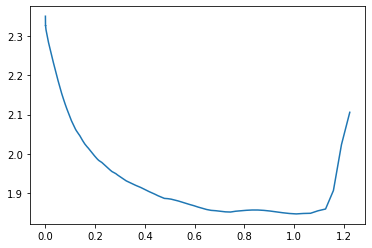

In [15]:
learning_rates = np.array(learning_rate_callback.learning_rates)
losses = np.array(learning_rate_callback.losses)

idx = losses < 10
learning_rates_clean = learning_rates[idx]
losses_clean = losses[idx]

plt.plot(learning_rates_clean, losses_clean)
best_idx = np.argmin(losses_clean)
best_learning_rate = learning_rates[best_idx] / 10.
print(f"approximate best learning rate: {best_learning_rate}")

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model = build_model(0.08090962767601013)

model_file = "mnist_digits_model.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
tensorboard_cb = get_tensorboard_cb()

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
)

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2892 - accuracy: 0.9152 - val_loss: 0.1418 - val_accuracy: 0.9596
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1200 - accuracy: 0.9650 - val_loss: 0.1033 - val_accuracy: 0.9694
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0805 - accuracy: 0.9759 - val_loss: 0.0946 - val_accuracy: 0.9730
Epoch 4/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0604 - accuracy: 0.9813 - val_loss: 0.0803 - val_accuracy: 0.9766
Epoch 5/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0467 - accuracy: 0.9855 - val_loss: 0.0673 - val_accuracy: 0.9796
Epoch 6/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0352 - accuracy: 0.9895 - val_loss: 0.0703 - val_accuracy: 0.9792
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.0727 - val_ac

In [18]:
model = keras.models.load_model(model_file)
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0635 - accuracy: 0.9817


[0.06345727294683456, 0.9817000031471252]